In [ ]:
!pip install pyLIQTR

  Using cached pyliqtr-1.3.9-py3-none-any.whl.metadata (9.0 kB)
INFO: pip is looking at multiple versions of openfermion to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.0/434.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 909.2/909.2 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 13.1 MB/s eta 0:00:00
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13818 sha256=2c9934fe3c0f71df64a9f142001e0ea9eefdbd42fe8fa97cc7b75a27310ebbcb
  Stored in directory: /root/.cache/pip/wheels/8b/e3/6c/3385b2db08b0985a87f5b117f98d0cb61a3ae3ca3bcbbd8307
Successfully built pubchempy
  Attempting uninstall: qualtran
    Found existing install

In [ ]:
import matplotlib.pyplot as plt
import cirq
import numpy as np
from qualtran.bloqs.data_loading.qrom import QROM
from qualtran._infra.gate_with_registers import get_named_qubits
from qualtran.cirq_interop import _bloq_to_cirq
from cirq.contrib.svg import SVGCircuit

# QROM Test

Cirq Circuit for QROM:


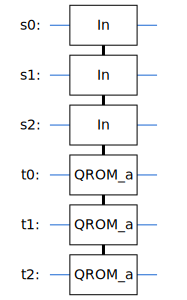

In [ ]:

# --- Setup: QROM constants
data = np.arange(8)
qrom = QROM([data], selection_bitsizes=(3,), target_bitsizes=(3,))

# --- Allocate qubits
ctrl_bits = sum(qrom.selection_bitsizes)  # log2(number of constants)
target_bits = sum(qrom.target_bitsizes)

# Qubits: address (control) + target
r = qrom.signature
quregs = get_named_qubits(r)

# --- Create Qualtran Operation
# qualtran_op = qrom.on_registers(**quregs)

selection_register = [cirq.NamedQubit('s' + str(i)) for i in range(ctrl_bits)]
target_register = [cirq.NamedQubit('t' + str(i)) for i in range(target_bits)]
qrom_cirq = qrom.as_composite_bloq().to_cirq_circuit(
    cirq_quregs= {'selection': selection_register, 'target0_':target_register}
)

# --- Decompose into Cirq

# cirq_ops = cirq.Circuit(qualtran_op)


# --- Output
print("Cirq Circuit for QROM:")
SVGCircuit(qrom_cirq)

In [ ]:
simulator = cirq.Simulator()
circuit = cirq.Circuit()
circuit.append(qrom_cirq)
circuit.append(cirq.measure(target_register, key='result'))

result = simulator.run(circuit, repetitions=10)
result = cirq.ResultDict(records={'result': result.records['result']})
print(result.histogram(key='result'))


Counter({0: 10})


In [ ]:
from qualtran.bloqs.arithmetic.trigonometric import ArcSin
arcsin = ArcSin(bitsize=10, num_frac=7)

In [ ]:
vals = {'x': 512, 'result': 0}
arcsin.as_composite_bloq().on_classical_vals(**vals)

{'x': 512, 'result': 536}

In [ ]:
np.arcsin(1/2)*1024

536.1651462126581

Cirq Circuit for QROM:


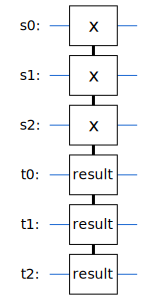

In [ ]:

# --- Setup: QROM constants
data = np.arange(8)
arcsin = ArcSin(bitsize=3, num_frac=2)

x_register = [cirq.NamedQubit('s' + str(i)) for i in range(3)]
result_register = [cirq.NamedQubit('t' + str(i)) for i in range(3)]
arcsin_cirq = arcsin.as_composite_bloq().to_cirq_circuit(
    cirq_quregs= {'x': x_register, 'result':result_register}
)

print("Cirq Circuit for QROM:")
SVGCircuit(arcsin_cirq)

In [ ]:
simulator = cirq.Simulator()
circuit = cirq.Circuit()
circuit.append(arcsin_cirq)
circuit.append(cirq.measure(result_register, key='result'))

result = simulator.simulate(circuit, initial_state=[1,1,0,0,0,0])
print(result.measurements['result'])

NotImplementedError: ArcSin does not support tensor simulation.

In [ ]:
np.arcsin(1.5/4)*4

1.5375870979825563

In [ ]:
6

0.75

# QROM + Inequality Test

## Utils

In [ ]:
import math
import cirq
class Comparator:
  def __init__(self, A, B):
    """
        :param A: The quantum register holding the first number
        :param B: The quantum register second number
    """
    self.A = A
    self.B = B
    self.length = len(A)


  def compare2(self, a0: cirq.NamedQubit, b0: cirq.NamedQubit, a1:cirq.NamedQubit, b1:cirq.NamedQubit, name: str) -> [cirq.Circuit, cirq.NamedQubit, cirq.NamedQubit]:
    # Compare a pair of two bits
    p = cirq.NamedQubit("ancilla_comp2_{}".format(name))
    compare2 = cirq.Circuit()
    compare2.append(cirq.X(p))
    compare2.append(cirq.CNOT(b1,a1), strategy=cirq.InsertStrategy.EARLIEST)
    compare2.append(cirq.CNOT(b0,a0), strategy=cirq.InsertStrategy.EARLIEST)
    # compare2.append(cirq.CSWAP(a1, a0, p), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    compare2.append(cirq.CCNOT(a1, a0, p), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    compare2.append(cirq.CCNOT(a1, p, a0), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    compare2.append(cirq.CCNOT(a1, a0, p), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)

    # compare2.append(cirq.CSWAP(a1, b1, b0), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    compare2.append(cirq.TOFFOLI(a1, b1, b0), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    compare2.append(cirq.TOFFOLI(a1, b0, b1), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    compare2.append(cirq.TOFFOLI(a1, b1, b0), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)

    compare2.append(cirq.CNOT(b0,a0), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)

    return compare2, a0, b0


  def finalizer(self, a: cirq.NamedQubit, b: cirq.NamedQubit) -> cirq.Circuit:
    # verify b>a

    self.anc1 = cirq.NamedQubit("ancilla_fin")

    final_cir = cirq.Circuit()
    final_cir.append(cirq.X(a), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    final_cir.append(cirq.TOFFOLI(a,b, self.anc1), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    final_cir.append(cirq.X(a), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)

    return final_cir

  def construct_circuit(self,) -> cirq.Circuit:
    self.circuit = cirq.Circuit()
    two_bitwise_compare = {}
    qubits_out_acc_layer = {}
    for j in range(0, int(math.log2(self.length))):
      two_bitwise_compare[j] = []
      qubits_out_acc_layer[j] = []
    # first layer
    for i in range(0, self.length//2):
      cir, a_out, b_out = self.compare2(self.A[2*i], self.B[2*i], self.A[2*i+1], self.B[2*i+1], name="0_"+str(i))
      two_bitwise_compare[0].append(cir)
      qubits_out_acc_layer[0].append([a_out, b_out])
    # later layer
    for j in range(1, int(math.log2(self.length))):
      for i in range(len(qubits_out_acc_layer[j-1])//2):
        cir, a_out, b_out = self.compare2(*qubits_out_acc_layer[j-1][2*i], *qubits_out_acc_layer[j-1][2*i+1], name=str(j)+"_"+str(i))
        two_bitwise_compare[j].append(cir)
        qubits_out_acc_layer[j].append([a_out, b_out])


    final_compare = self.finalizer(*qubits_out_acc_layer[int(math.log2(self.length))-1][0])
    for j in range(0, int(math.log2(self.length))):
      self.circuit.append((two_bitwise_compare[j]), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    self.circuit.append(final_compare, strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    return self.circuit

In [ ]:
class StatePrepIneq:
  """
  Implement inequality test based method in https://arxiv.org/abs/1807.03206 with regular ampltitude amplification technqiues

  Attributes:
    -----------
    num_out_qubits : int
        Number of qubits for output register

    num_data_qubits : int
        Number of qubits to estimate the output data from the oracle

    black_box: cirq.Circuit
        The oracle to generate the output data.

    input_data : List[float]
        (Optional) List of amplitudes when black_box is None

  Methods:
    --------
    good_state_preparation() -> cirq.Circuit
        Generates 'good state' cirq.Circuit.

    amplitude_amplification(num_iteration) -> cirq.Circuit
        Generates the amplitude amplification circuit based on the 'good' circuit.

    construct_circuit() -> None
        Combine good_state_preparation and amplitude_amplification circuit

    get_output() -> List[float]
        Simulate results and get ampltiudes of the output state
  """
  def __init__(self, num_out_qubits: int, num_data_qubits: int, input_data: list =None, qrom: cirq.Circuit = None)-> None:
    """
    :param num_out_qubits: number of qubits for output register
    :param num_data_qubits: number of qubits to estimate the output data from the oracle
    :param input_data: if 'black_box' is None, user can direct input the list of amplitudes as 'input_data'
    :param qrom: the oracle to generate the output data.
    """
    self.num_out_qubits = num_out_qubits
    self.num_data_qubits = num_data_qubits
    self.input_data = input_data

    self.out = [cirq.NamedQubit('out' + str(i)) for i in range(num_out_qubits)]
    self.data = [cirq.NamedQubit('data' + str(i)) for i in range(num_data_qubits)]
    self.ref = [cirq.NamedQubit('ref' + str(i)) for i in range(num_data_qubits)]
    self.flag = cirq.NamedQubit('flag')
    if qrom:
        # if there is input blackbox, directly apply the oracle on out and data registers
        self.blackbox = blackbox(self.out, self.data, qrom=qrom)

  def good_state_preparation(self,) -> cirq.Circuit:
    """
    Generate the good state at |0>_ref|0>-flag.
    Implement Eq.(7) in the paper
    """
    circuit = cirq.Circuit()

    # intializer
    for i in range(self.num_out_qubits):
      circuit.append(cirq.H(self.out[i]))
    if self.blackbox is None:
      # if there is no input blackbox, apply simple basis encoding for input_data
      def ai_to_gate(ai):
        circ = cirq.Circuit()
        for i, val in enumerate(ai):
          if val == '1':
            circ.append(cirq.X(self.data[self.num_data_qubits-1-i]))
        return circ

      def oracle(A, d, n):
          """ Loads the data array onto the circuit, controlled by register out as index. """
          oracle = cirq.Circuit()
          for i in range(2**d):
              circ_ai = ai_to_gate(A[i])
              circ_ai_to_op = cirq.CircuitOperation(circ_ai.freeze())
              ai_encode_gate = circ_ai_to_op.controlled_by(*self.out, control_values=[int(k) for k in format(i, "b").zfill(self.num_out_qubits)])
              oracle.append(ai_encode_gate)
          return oracle
      # Apply blackbox
      self.blackbox = oracle(self.input_data, self.num_out_qubits, self.num_data_qubits)
      circuit.append(self.blackbox, strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    else:
      circuit.append(self.blackbox, strategy=cirq.InsertStrategy.NEW_THEN_INLINE)

    # initialize ref
    for i in range(self.num_data_qubits):
      circuit.append(cirq.H(self.ref[i]))

    # compare ref to data
    comparator = Comparator(self.ref, self.data)
    compare_circ = comparator.construct_circuit()

    circuit.append(compare_circ, strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    circuit.append(cirq.X(comparator.anc1))
    circuit.append(cirq.CNOT(comparator.anc1, self.flag))
    circuit.append(cirq.X(comparator.anc1))

    # uncompute comparator
    inv_compare = cirq.inverse(compare_circ)
    circuit.append(inv_compare, strategy=cirq.InsertStrategy.NEW_THEN_INLINE)

    # unprepare superposition from ref
    for i in range(self.num_data_qubits):
      circuit.append(cirq.H(self.ref[i]))

    return circuit

  def amplitude_amplification(self, num_iteration: int) -> cirq.Circuit:

    #define components
    def phase_oracle() -> cirq.Circuit:
      """
      Negate the amplitude with |0>_ref |0>_flag
      """
      circ = cirq.Circuit()
      circ.append(cirq.X(self.flag))
      circ.append(cirq.H(self.flag)) # on flag
      circ.append(cirq.XPowGate().controlled(self.num_data_qubits, control_values=[0]*self.num_data_qubits).on(*self.ref, self.flag))
      circ.append(cirq.H(self.flag)) # on flag
      circ.append(cirq.X(self.flag))
      return circ

    def zero_reflection(qubits: list) -> cirq.Circuit:
      """
      Reflect zero state.
      Implement I - 2|0><0| over all qubits
      """
      circ = cirq.Circuit()
      for i in range(len(qubits)):
        circ.append(cirq.X(qubits[i]))

      circ.append(cirq.H(qubits[-1])) # on flag
      circ.append(cirq.XPowGate().controlled(self.num_out_qubits+2*self.num_data_qubits).on(*qubits))
      circ.append(cirq.H(qubits[-1])) # on flag

      for i in range(len(qubits)):
        circ.append(cirq.X(qubits[i]))

      return circ

    circ = cirq.Circuit()
    oracle = phase_oracle()
    good_state_preparation = self.good_state_preparation()
    reflection = zero_reflection(self.out+self.data+self.ref+[self.flag])


    circ.append(good_state_preparation, strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    for i in range(num_iteration):
      circ.append(oracle, strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
      circ.append(cirq.inverse(good_state_preparation), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
      circ.append(reflection, strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
      circ.append(good_state_preparation, strategy=cirq.InsertStrategy.NEW_THEN_INLINE)

    return circ

  def construct_circuit(self,num_iteration: int) -> None:
    self.output_circuit = self.amplitude_amplification(num_iteration=num_iteration) # math.floor(np.sqrt(2**self.num_data_qubits))
    # uncompute data
    self.output_circuit.append(cirq.inverse(self.blackbox), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)

  def get_output(self) -> list:
    # measurement
    self.output_circuit.append(cirq.measure(*(self.out+self.ref+[self.flag]), key="result"))
    s = cirq.Simulator()
    samples = s.run(self.output_circuit, repetitions=1000)
    samples = cirq.ResultDict(records={'result': samples.records['result']})
    results = samples.histogram(key="result")
    care_results = []
    for i in range(2**self.num_out_qubits):
      binarized_i = format(i, "b").zfill(self.num_out_qubits)
      binarized_i = binarized_i[::-1]
      care_position = int(binarized_i+"0"*self.num_data_qubits+"0", 2)
      care_results.append(results[care_position])

    amplitude = np.sqrt(np.array(care_results)/(sum(care_results)))

    return amplitude

## Main

In [ ]:
def generate_coeff(n: int, sigma: float) -> np.ndarray:
  """
  Compute a vector of 2**n coefficients of gaussian function
  """

  N = 2**n
  x = np.arange(N)
  x = (2 * x) / (N - 1) - 1
  coeffs = np.exp(-(x**2/(2*sigma**2)))
  return coeffs

def blackbox(selection_register, target_register, qrom):
  qrom_cirq = qrom.as_composite_bloq().to_cirq_circuit(
    cirq_quregs= {'selection': selection_register, 'target0_':target_register}
  )
  return qrom_cirq

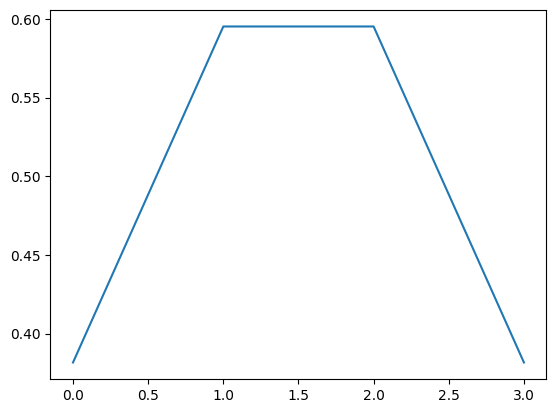

In [ ]:
system_nqubits = 2
data_nqubits = 2
y = generate_coeff(system_nqubits, sigma = 1)
plt.plot(np.arange(0,2**system_nqubits), y/np.linalg.norm(y))

In [ ]:
y = (y*2**data_nqubits).astype(np.int8)
qrom = QROM([y], selection_bitsizes=(system_nqubits,), target_bitsizes=(data_nqubits,))
state_prep = StatePrepIneq(num_out_qubits=system_nqubits, num_data_qubits=data_nqubits, qrom=qrom)
state_prep.construct_circuit(num_iteration = math.ceil((np.pi/4)*np.sqrt(2**system_nqubits)/np.linalg.norm(y)))

amplitudes = state_prep.get_output()

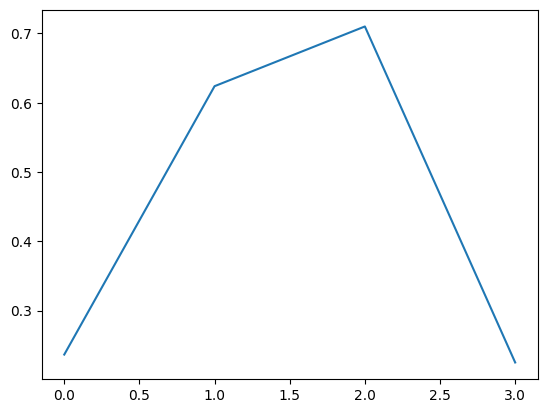

In [ ]:
plt.plot(np.arange(0,2**system_nqubits), amplitudes)

# QSVT

In [ ]:
###
### General imports
###

import numpy                as np
import numpy.linalg         as nla
import scipy.linalg         as sla
import scipy.special        as sfn

import matplotlib.pyplot    as plt
import matplotlib_inline    as mpli
import sys                  as sys

from IPython.display        import display, clear_output

from numpy                  import int8 as int8

###
### Angle generation imports
###

from    pyLIQTR.phase_factors.optimization.fitter                import  Fitter
from    pyLIQTR.phase_factors.optimization.expander              import  Expander
from    pyLIQTR.phase_factors.optimization.angler_optimization   import  Angler_opt
from    pyLIQTR.clam.simqsp                                      import  SimQSP
import  pyLIQTR.clam.operators                                   as      qops
import  pyLIQTR.utils.plot_helpers                               as      ph

###
### Arbitrary precision arithmetic
###

import mpmath                            as mpm
mpm.mp.prec = 512

###
### Ploting and text output settings
###

mpli.backend_inline.set_matplotlib_formats('svg')
plt.rcParams['text.usetex'] = False
np.set_printoptions(precision=2)
sys.set_int_max_str_digits(100000)

In [ ]:
deg   = 30;       parity   = 0
kappa = 10;       beta     = 1.0

exp_ite  =  lambda x : mpm.exp(-beta*np.abs(x))